# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

**Цель**

Построить модель, которая предскажет температуру стали.

## Первичный анализ данных, план проекта

In [1]:
!pip install lightgbm
!pip install --user shap

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    RandomizedSearchCV, 
    train_test_split, 
    cross_val_score
)
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 80523

In [3]:
try:
    data_arc = pd.read_csv('C:\D\Project\datasets\data_arc_new.csv', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
    data_bulk = pd.read_csv('C:\D\Project\datasets\data_bulk_new.csv')
    data_bulk_time = pd.read_csv('C:\D\Project\datasets\data_bulk_time_new.csv', parse_dates=list(data_bulk.columns)[1:])
    data_gas = pd.read_csv('C:\D\Project\datasets\data_gas_new.csv')
    data_temp = pd.read_csv('C:\D\Project\datasets\data_temp_new.csv', parse_dates=['Время замера'])
    data_wire = pd.read_csv('C:\D\Project\datasets\data_wire_new.csv')
    data_wire_time = pd.read_csv('C:\D\Project\datasets\data_wire_time_new.csv', parse_dates=list(data_wire.columns)[1:])
except:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv', parse_dates=list(data_bulk.columns)[1:])
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv', parse_dates=['Время замера'])
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv', parse_dates=list(data_wire.columns)[1:])

**data_arc**

In [4]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [5]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [6]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [7]:
data_arc.columns = [
    'key',
    'start_of_arc_heating',
    'end_of_arc_heating', 
    'active_power', 
    'reactive_power'
]

In [8]:
def boxplot_and_hist(diag, data, x, title, xlim=None, **args):
    if not xlim is None:
            plt.xlim(xlim)
    
    if diag == 'hist':
        sns.histplot(data=data, x=x, kde=True, **args)
        plt.title(title)
        plt.show()
    elif diag == 'box':
        sns.boxplot(data=data, x=x, orient='h', **args)
        plt.title(title)
        plt.show()

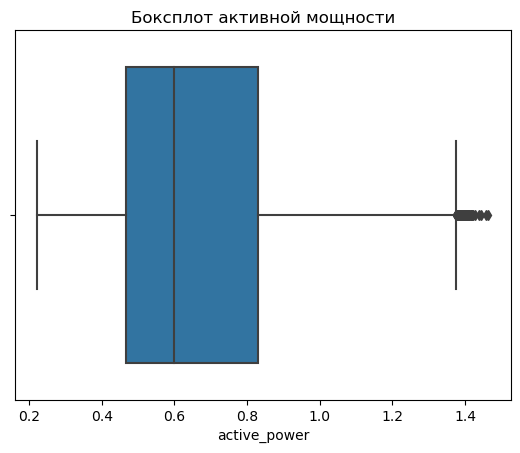

In [9]:
boxplot_and_hist(diag='box', data=data_arc, x='active_power', title='Боксплот активной мощности')

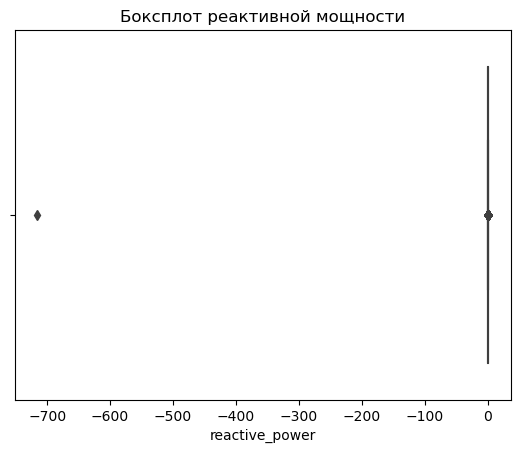

In [10]:
boxplot_and_hist(diag='box', data=data_arc, x='reactive_power', title='Боксплот реактивной мощности')

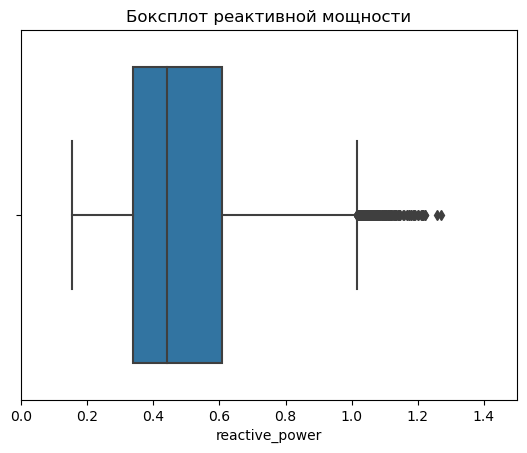

In [11]:
boxplot_and_hist(diag='box', data=data_arc, x='reactive_power', title='Боксплот реактивной мощности', xlim=(0, 1.5))

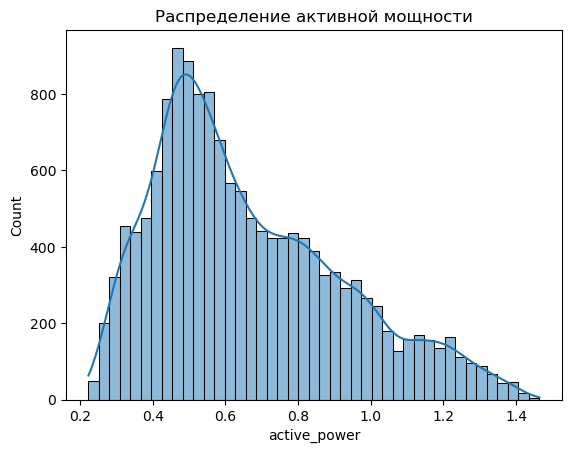

In [12]:
boxplot_and_hist(diag='hist', data=data_arc, x='active_power', title='Распределение активной мощности')

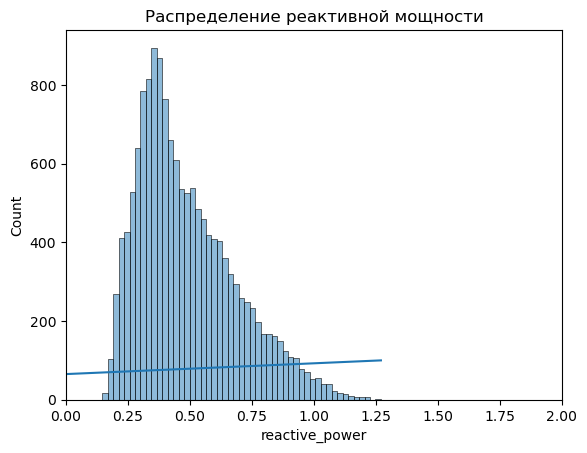

In [13]:
boxplot_and_hist(diag='hist', data=data_arc, x='reactive_power', title='Распределение реактивной мощности', xlim=(0, 2))

Имеется один выброс в реактивной мощности, распределение имеет положительную асимметрию

**data_bulk**

In [14]:
data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [15]:
data_bulk.columns = [i.replace(' ', '_').lower() for i in data_bulk.columns]

In [16]:
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [17]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [18]:
data_bulk.isnull().mean()

key        0.000000
bulk_1     0.919463
bulk_2     0.992969
bulk_3     0.585171
bulk_4     0.675935
bulk_5     0.975391
bulk_6     0.815916
bulk_7     0.992010
bulk_8     0.999680
bulk_9     0.993928
bulk_10    0.943752
bulk_11    0.943432
bulk_12    0.217002
bulk_13    0.994247
bulk_14    0.103228
bulk_15    0.281560
dtype: float64

In [19]:
data_bulk['key'].duplicated().sum()

0

Чаще всего используют сыпучий материал номер 14 и 12. Пропуски можно заполнить 0, тк они, скорее всего, означают неиспользование материала, надо перевести все колонки в тип int

**data_bulk_time**

In [20]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [21]:
data_bulk_time.columns = [i.replace(' ', '_').lower() for i in data_bulk_time.columns]

In [22]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [23]:
data_bulk_time.isnull().mean()

key        0.000000
bulk_1     0.919463
bulk_2     0.992969
bulk_3     0.585171
bulk_4     0.675935
bulk_5     0.975391
bulk_6     0.815916
bulk_7     0.992010
bulk_8     0.999680
bulk_9     0.993928
bulk_10    0.943752
bulk_11    0.943432
bulk_12    0.217002
bulk_13    0.994247
bulk_14    0.103228
bulk_15    0.281560
dtype: float64

In [24]:
data_bulk_time.isnull().mean() == data_bulk.isnull().mean()

key        True
bulk_1     True
bulk_2     True
bulk_3     True
bulk_4     True
bulk_5     True
bulk_6     True
bulk_7     True
bulk_8     True
bulk_9     True
bulk_10    True
bulk_11    True
bulk_12    True
bulk_13    True
bulk_14    True
bulk_15    True
dtype: bool

In [25]:
data_bulk_time['key'].duplicated().sum()

0

Все пропуски соответствуют пропускам материала, дубликатов нет

**data_gas**

In [26]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [27]:
data_gas.columns = ['key', 'gas_1']

In [28]:
data_gas.describe()

,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [29]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


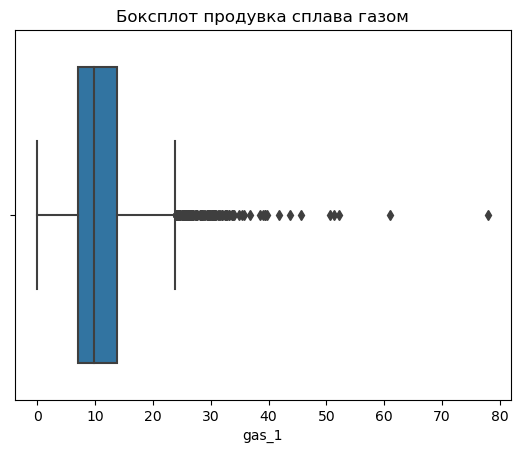

In [30]:
boxplot_and_hist(diag='box', data=data_gas, x='gas_1', title='Боксплот продувка сплава газом')

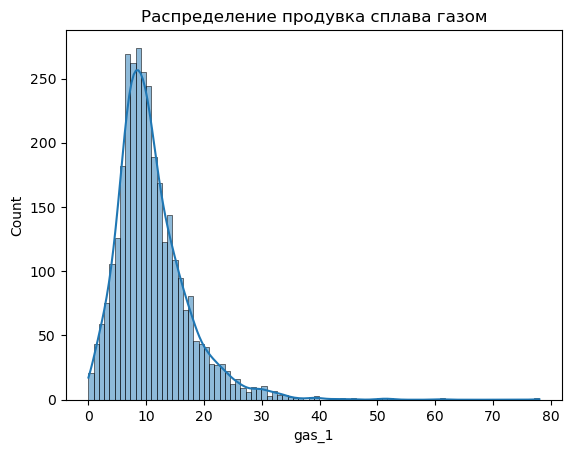

In [31]:
boxplot_and_hist(diag='hist', data=data_gas, x='gas_1', title='Распределение продувка сплава газом')

Пропусков нет, имеет положительную асимметрию - длинный "хвост" из выбросов

**data_temp**

In [32]:
data_temp.head(5)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [33]:
data_temp.columns = ['key', 'time', 'temp']

In [34]:
data_temp.describe()

,key,temp
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [35]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     18092 non-null  int64         
 1   time    18092 non-null  datetime64[ns]
 2   temp    14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [36]:
data_temp.isnull().mean()

key     0.000000
time    0.000000
temp    0.189421
dtype: float64

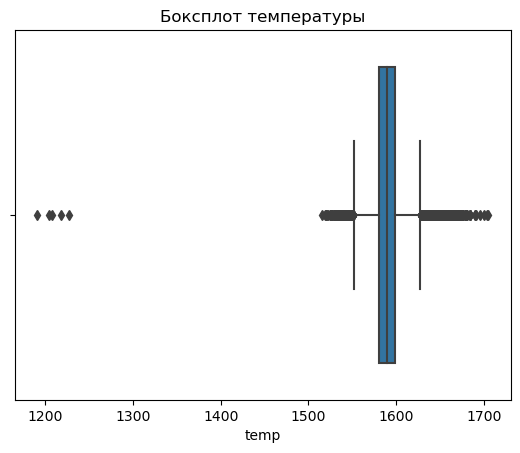

In [37]:
boxplot_and_hist(diag='box', data=data_temp, x='temp', title='Боксплот температуры')

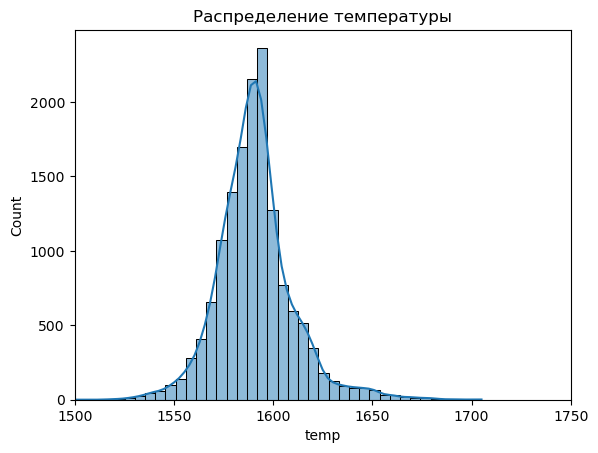

In [38]:
boxplot_and_hist(diag='hist', data=data_temp, x='temp', title='Распределение температуры', xlim=(1500, 1750), bins=100)

Есть пропуски можно заполнить медианой или средним, нормальное распределение, имеются выбросы, температуру надо перевести в тип int

**data_wire**

In [39]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
data_wire.columns = [i.replace(' ', '_').lower() for i in data_wire.columns]

In [41]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [42]:
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [43]:
data_wire['key'].duplicated().sum()

0

In [44]:
data_wire.isnull().mean()

key       0.000000
wire_1    0.008439
wire_2    0.649789
wire_3    0.979552
wire_4    0.995456
wire_5    0.999675
wire_6    0.976306
wire_7    0.996430
wire_8    0.993833
wire_9    0.990587
dtype: float64

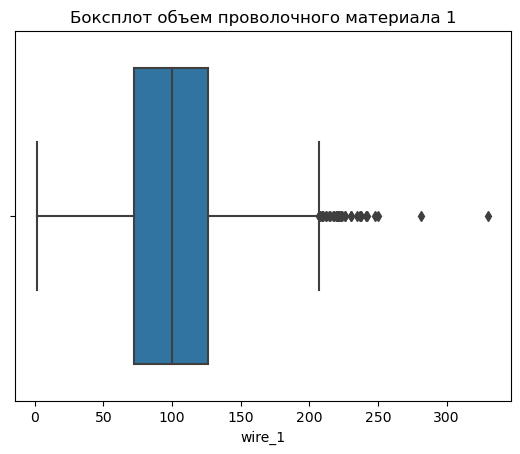

In [45]:
boxplot_and_hist(diag='box', data=data_wire, x='wire_1', title='Боксплот объем проволочного материала 1')

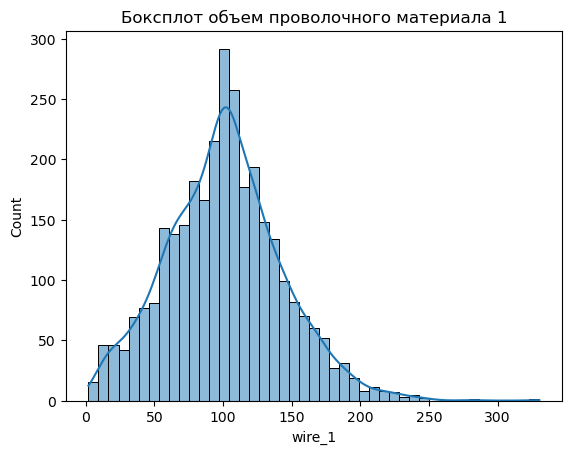

In [46]:
boxplot_and_hist(diag='hist', data=data_wire, x='wire_1', title='Боксплот объем проволочного материала 1')

Чаще всего используют проволочные материалы под номером 1, пропуски можно заполнить 0, тк они означают неиспользование материала

**data_wire_time**

In [47]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [48]:
data_wire_time.columns = [i.replace(' ', '_').lower() for i in data_wire_time.columns]

In [49]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [50]:
data_wire_time.isnull().mean()

key       0.000000
wire_1    0.008439
wire_2    0.649789
wire_3    0.979552
wire_4    0.995456
wire_5    0.999675
wire_6    0.976306
wire_7    0.996430
wire_8    0.993833
wire_9    0.990587
dtype: float64

In [51]:
data_wire_time.isnull().mean() == data_wire.isnull().mean()

key       True
wire_1    True
wire_2    True
wire_3    True
wire_4    True
wire_5    True
wire_6    True
wire_7    True
wire_8    True
wire_9    True
dtype: bool

Дубликатов нет, все пропуски совпадают с пропусками материалов

**Вывод:**

У всех таблиц неправильный нейминг колонок, даты переведены в формат даты. Таргет - последняя измеренная температура в data_temp. Метрика - MAE, тк присутствуют выбросы

**1. Данные об электродах (data_arc)**

Отсутсвуют пропуски, имеется выброс в реактивной мощности, распределение имеет смещение влево, выброс можно удалить

**2. Данные о подаче сыпучих материалов (объём) (data_bulk)**

Чаще всего используют сыпучий материал номер 14 и 12. Есть пропуски, которые означают, что материал не использовали, можно заполнить 0. Надо перевести все столбцы в int

**3. Данные о подаче сыпучих материалов (время) (data_bulk_time)**

Пропуски совпадают с пропусками данных о подаче сыпучих материалов (объем)

**4. Данные о продувке сплава газом (data_gas)**

Пропусков нет, имеет нормальное распределение, но длинный "хвост" из выбросов

**5. Результаты измерения температуры (data_temp)**

Есть пропуски, можно заполнить медианой или средним. Имеет нормальное распределение, есть выбросы, температуру надо перевести в тип int

**6. Данные о проволочных материалах (объём) (data_wire)**

Чаще всего используют проволочные материалы под номером 1, пропуски можно заполнить 0, тк они означают неиспользование материала

**7. Данные о проволочных материалах (время) (data_wire_time)**

Пропуски совпадают с пропусками данных о проволочных материалов (объем)

# План работы

1. Заполнить пропуски, удалить выбросы, изменить тип данных
2. Подготовить таблицы к объединения и объединить
3. Посмотреть корреляцию, отобрать признаки
4. Разделить на 2 выборки - обучающую и тестовую (тк данных не шибко много)
5. Обучить несколько моделей с разными гиперпараметрами, выбрать лучшую модель

## Предобработка данных, разработка модели

### Предобработка данных

In [52]:
data_arc = data_arc.query('reactive_power > 0')
data_bulk = data_bulk.fillna(0).astype(int)
data_gas = data_gas.query('gas_1 < 60')
data_wire = data_wire.fillna(0).astype(int)

data_temp = data_temp.groupby('key')
data_temp = data_temp.head(1).merge(data_temp.tail(1), how='outer', on='key')
data_temp.columns = ['key', 'start_time', 'start_temp', 'end_time', 'end_temp']

In [53]:
data_temp

,key,start_time,start_temp,end_time,end_temp
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0
...,...,...,...,...,...
3211,3237,2019-09-06 11:31:15,1569.0,2019-09-06 11:55:45,NaN
3212,3238,2019-09-06 12:16:15,1584.0,2019-09-06 12:34:37,NaN
3213,3239,2019-09-06 14:16:50,1598.0,2019-09-06 15:09:55,NaN
3214,3240,2019-09-06 15:25:21,1617.0,2019-09-06 16:35:26,NaN


In [54]:
data_temp.drop(['start_time', 'end_time'], axis=1, inplace=True)

In [55]:
data_temp.dropna(inplace=True)

In [56]:
data_temp = data_temp.astype(int)

In [57]:
data_temp

,key,start_temp,end_temp
0,1,1571,1613
1,2,1581,1602
2,3,1596,1599
3,4,1601,1625
4,5,1576,1602
...,...,...,...
2472,2495,1570,1591
2473,2496,1554,1591
2474,2497,1571,1589
2475,2498,1591,1594


In [58]:
data_arc['time_of_arc_heating'] = data_arc['end_of_arc_heating'] - data_arc['start_of_arc_heating']

In [59]:
data_arc

,key,start_of_arc_heating,end_of_arc_heating,active_power,reactive_power,time_of_arc_heating
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0 days 00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0 days 00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0 days 00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0 days 00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0 days 00:02:28
...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,0 days 00:02:37
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,0 days 00:03:00
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,0 days 00:03:04
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,0 days 00:00:57


In [60]:
data_arc = data_arc.drop(['start_of_arc_heating', 'end_of_arc_heating'], axis=1).groupby('key')
new_data_arc = pd.DataFrame({
    'sum_time_of_arc_heating': data_arc['time_of_arc_heating'].sum(), 
    'sum_active_power': data_arc.active_power.sum(),
    'sum_reactive_power': data_arc.reactive_power.sum()}
)

In [61]:
new_data_arc

,sum_time_of_arc_heating,sum_active_power,sum_reactive_power
key,,,
1,0 days 00:18:18,3.036730,2.142821
2,0 days 00:13:31,2.139408,1.453357
3,0 days 00:10:55,4.063641,2.937457
4,0 days 00:12:21,2.706489,2.056992
5,0 days 00:14:29,2.252950,1.687991
...,...,...,...
3237,0 days 00:15:09,2.541872,2.025417
3238,0 days 00:09:06,1.374821,1.038103
3239,0 days 00:20:16,4.848005,3.541541


In [62]:
new_data_arc.reset_index(inplace=True)

In [63]:
new_data_arc

,key,sum_time_of_arc_heating,sum_active_power,sum_reactive_power
0,1,0 days 00:18:18,3.036730,2.142821
1,2,0 days 00:13:31,2.139408,1.453357
2,3,0 days 00:10:55,4.063641,2.937457
3,4,0 days 00:12:21,2.706489,2.056992
4,5,0 days 00:14:29,2.252950,1.687991
...,...,...,...,...
3209,3237,0 days 00:15:09,2.541872,2.025417
3210,3238,0 days 00:09:06,1.374821,1.038103
3211,3239,0 days 00:20:16,4.848005,3.541541
3212,3240,0 days 00:13:59,3.317679,2.373552


In [64]:
data_wire['sum_wire'] = data_wire.drop('key', axis=1).sum(axis=1)

In [65]:
data_wire

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,sum_wire
0,1,60,0,0,0,0,0,0,0,0,60
1,2,96,0,0,0,0,0,0,0,0,96
2,3,91,0,0,0,0,0,0,0,0,91
3,4,89,0,0,0,0,0,0,0,0,89
4,5,89,9,0,0,0,0,0,0,0,98
...,...,...,...,...,...,...,...,...,...,...,...
3076,3237,38,0,0,0,0,0,0,0,0,38
3077,3238,56,0,0,0,0,0,0,0,0,56
3078,3239,143,0,0,0,0,0,0,0,0,143
3079,3240,34,0,0,0,0,0,0,0,0,34


In [66]:
data_bulk['sum_bulk'] = data_bulk.drop('key', axis=1).sum(axis=1)

In [67]:
data_bulk

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,sum_bulk
0,1,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154,553
1,2,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154,582
2,3,0,0,0,34,0,0,0,0,0,0,0,205,0,152,153,544
3,4,0,0,0,81,0,0,0,0,0,0,0,207,0,153,154,595
4,5,0,0,0,78,0,0,0,0,0,0,0,203,0,151,152,584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0,0,170,0,0,0,0,0,0,0,0,252,0,130,206,758
3125,3238,0,0,126,0,0,0,0,0,0,0,0,254,0,108,106,594
3126,3239,0,0,0,0,0,114,0,0,0,0,0,158,0,270,88,630
3127,3240,0,0,0,0,0,26,0,0,0,0,0,0,0,192,54,272


In [68]:
features = new_data_arc.merge(data_gas, on='key', how='inner')
features = features.merge(data_wire, on='key', how='inner')
features = features.merge(data_bulk, on='key', how='inner')
features = features.merge(data_temp, on='key', how='inner')

In [69]:
features

,key,sum_time_of_arc_heating,sum_active_power,sum_reactive_power,gas_1,wire_1,wire_2,wire_3,wire_4,wire_5,...,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,sum_bulk,start_temp,end_temp
0,1,0 days 00:18:18,3.036730,2.142821,29.749986,60,0,0,0,0,...,0,0,0,206,0,150,154,553,1571,1613
1,2,0 days 00:13:31,2.139408,1.453357,12.555561,96,0,0,0,0,...,0,0,0,206,0,149,154,582,1581,1602
2,3,0 days 00:10:55,4.063641,2.937457,28.554793,91,0,0,0,0,...,0,0,0,205,0,152,153,544,1596,1599
3,4,0 days 00:12:21,2.706489,2.056992,18.841219,89,0,0,0,0,...,0,0,0,207,0,153,154,595,1601,1625
4,5,0 days 00:14:29,2.252950,1.687991,5.413692,89,9,0,0,0,...,0,0,0,203,0,151,152,584,1576,1602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2322,2495,0 days 00:12:03,3.168133,2.210936,7.125735,89,0,0,0,0,...,0,90,0,256,0,129,223,719,1570,1591
2323,2496,0 days 00:15:40,4.174918,2.872031,9.412616,114,0,0,0,0,...,0,122,0,256,0,129,226,796,1554,1591
2324,2497,0 days 00:09:29,3.605239,2.452092,6.271699,94,9,0,0,0,...,0,0,0,230,0,124,226,665,1571,1589
2325,2498,0 days 00:12:30,3.202310,2.239820,14.953657,118,0,0,0,0,...,0,101,0,206,0,129,207,733,1591,1594


In [70]:
features.set_index('key', inplace=True)
target = features['end_temp']
features = features.drop(['end_temp'], axis=1)

In [71]:
features

,sum_time_of_arc_heating,sum_active_power,sum_reactive_power,gas_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,...,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,sum_bulk,start_temp
key,,,,,,,,,,,,,,,,,,,,,
1,0 days 00:18:18,3.036730,2.142821,29.749986,60,0,0,0,0,0,...,0,0,0,0,206,0,150,154,553,1571
2,0 days 00:13:31,2.139408,1.453357,12.555561,96,0,0,0,0,0,...,0,0,0,0,206,0,149,154,582,1581
3,0 days 00:10:55,4.063641,2.937457,28.554793,91,0,0,0,0,0,...,0,0,0,0,205,0,152,153,544,1596
4,0 days 00:12:21,2.706489,2.056992,18.841219,89,0,0,0,0,0,...,0,0,0,0,207,0,153,154,595,1601
5,0 days 00:14:29,2.252950,1.687991,5.413692,89,9,0,0,0,0,...,0,0,0,0,203,0,151,152,584,1576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0 days 00:12:03,3.168133,2.210936,7.125735,89,0,0,0,0,0,...,0,0,90,0,256,0,129,223,719,1570
2496,0 days 00:15:40,4.174918,2.872031,9.412616,114,0,0,0,0,0,...,0,0,122,0,256,0,129,226,796,1554
2497,0 days 00:09:29,3.605239,2.452092,6.271699,94,9,0,0,0,0,...,0,0,0,0,230,0,124,226,665,1571


In [72]:
features['sum_time_of_arc_heating'] = features['sum_time_of_arc_heating'].dt.seconds

In [73]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2327 entries, 1 to 2499
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sum_time_of_arc_heating  2327 non-null   int64  
 1   sum_active_power         2327 non-null   float64
 2   sum_reactive_power       2327 non-null   float64
 3   gas_1                    2327 non-null   float64
 4   wire_1                   2327 non-null   int32  
 5   wire_2                   2327 non-null   int32  
 6   wire_3                   2327 non-null   int32  
 7   wire_4                   2327 non-null   int32  
 8   wire_5                   2327 non-null   int32  
 9   wire_6                   2327 non-null   int32  
 10  wire_7                   2327 non-null   int32  
 11  wire_8                   2327 non-null   int32  
 12  wire_9                   2327 non-null   int32  
 13  sum_wire                 2327 non-null   int64  
 14  bulk_1                  

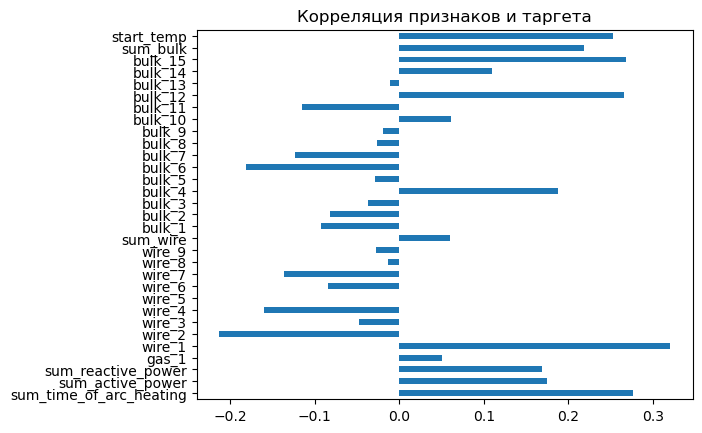

In [74]:
features.corrwith(target).plot(kind='barh')
plt.title('Корреляция признаков и таргета')
plt.show()

In [75]:
features = features[[
    'start_temp', 
    'sum_bulk', 
    'bulk_15', 
    'bulk_14', 
    'bulk_12', 
    'bulk_11', 
    'bulk_10',
    'bulk_7',
    'bulk_6', 
    'bulk_4', 
    'bulk_3', 
    'bulk_2',
    'bulk_1',
    'wire_7',
    'wire_4',
    'wire_2',
    'wire_1', 
    'sum_reactive_power',
    'sum_active_power',
    'sum_time_of_arc_heating', 
    'gas_1']]

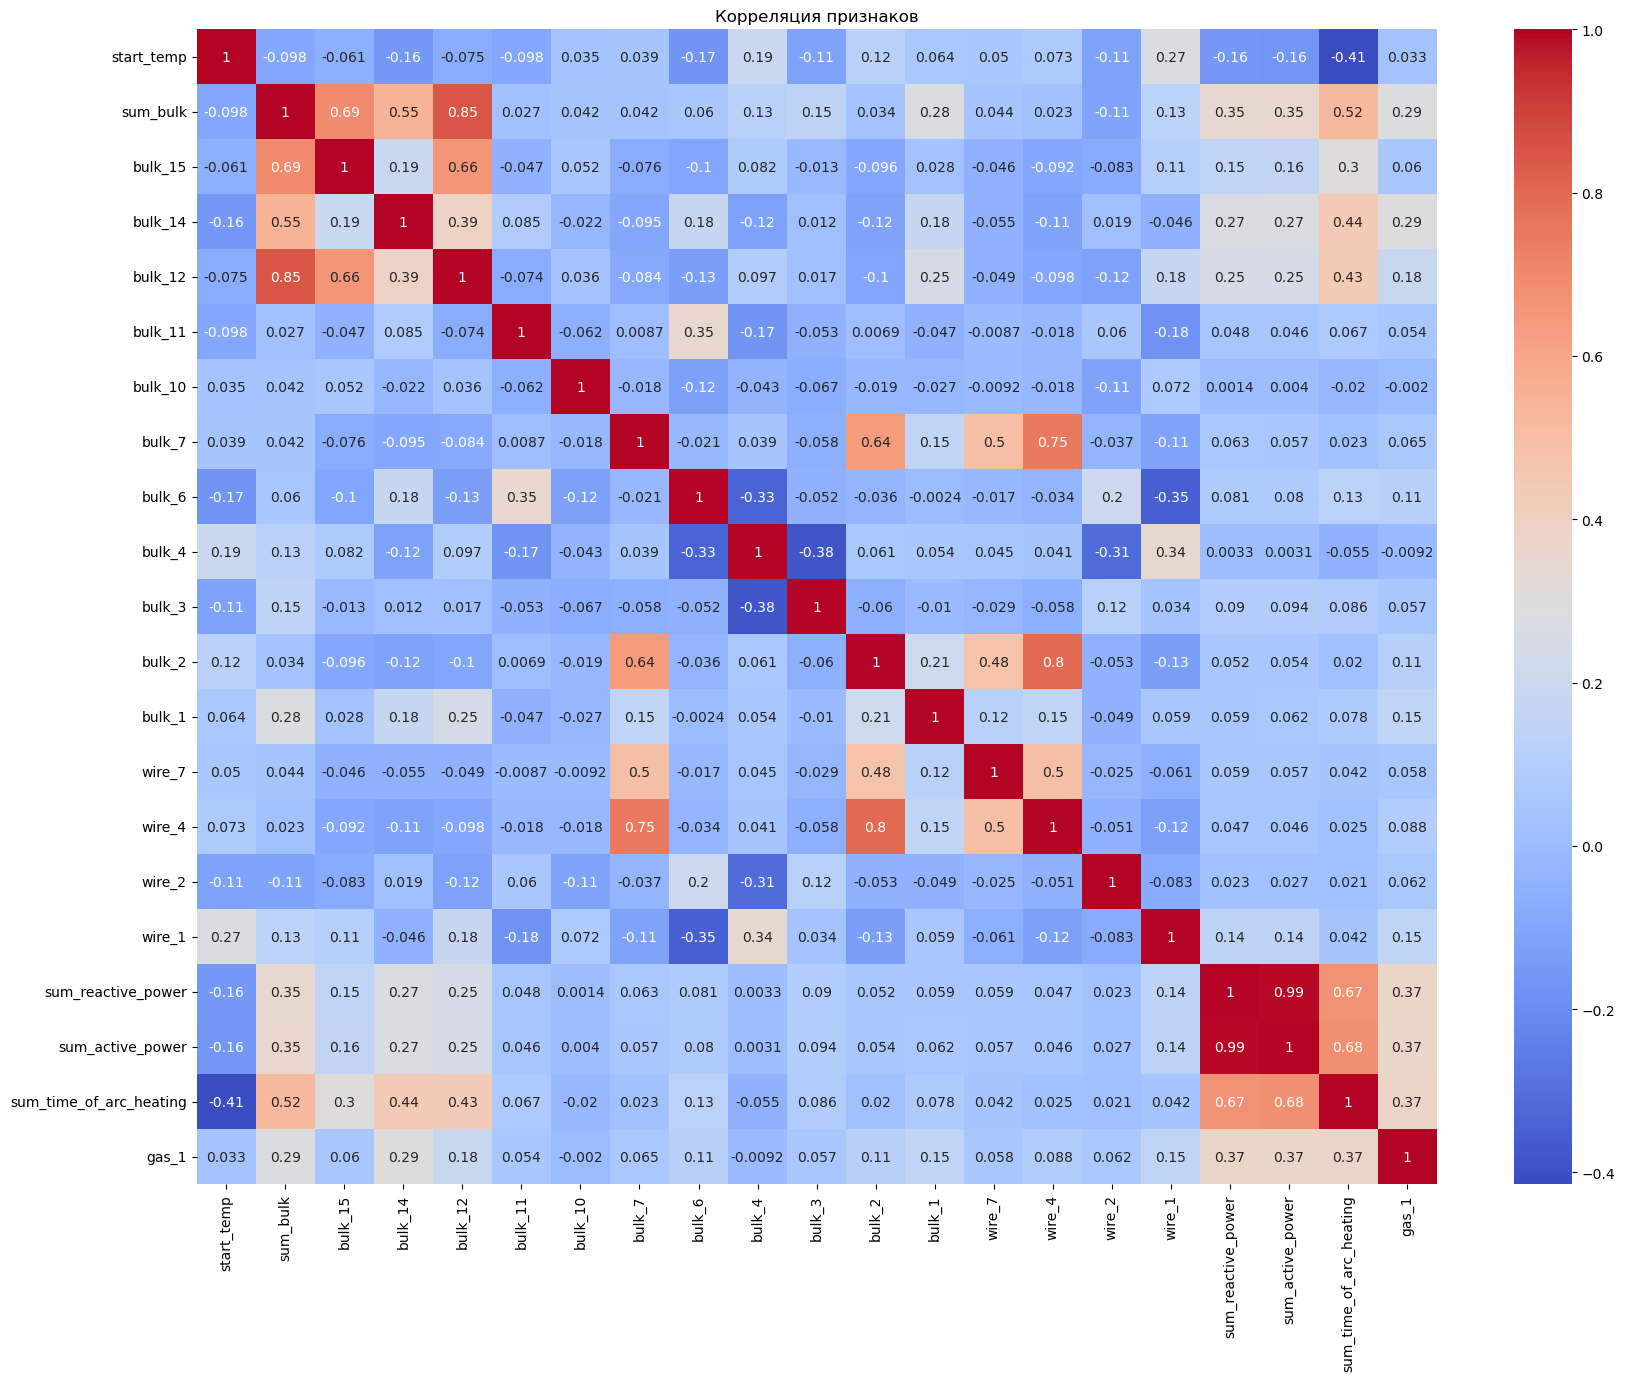

In [76]:
plt.figure(figsize=(20, 15))
plt.title('Корреляция признаков')
sns.heatmap(features.corr(method='spearman'), annot = True, cmap="coolwarm")
plt.show()

In [77]:
features = features.drop(['sum_reactive_power', 'bulk_12'], axis=1)

In [78]:
features

,start_temp,sum_bulk,bulk_15,bulk_14,bulk_11,bulk_10,bulk_7,bulk_6,bulk_4,bulk_3,bulk_2,bulk_1,wire_7,wire_4,wire_2,wire_1,sum_active_power,sum_time_of_arc_heating,gas_1
key,,,,,,,,,,,,,,,,,,,
1,1571,553,154,150,0,0,0,0,43,0,0,0,0,0,0,60,3.036730,1098,29.749986
2,1581,582,154,149,0,0,0,0,73,0,0,0,0,0,0,96,2.139408,811,12.555561
3,1596,544,153,152,0,0,0,0,34,0,0,0,0,0,0,91,4.063641,655,28.554793
4,1601,595,154,153,0,0,0,0,81,0,0,0,0,0,0,89,2.706489,741,18.841219
5,1576,584,152,151,0,0,0,0,78,0,0,0,0,0,9,89,2.252950,869,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570,719,223,129,0,90,0,0,0,21,0,0,0,0,0,89,3.168133,723,7.125735
2496,1554,796,226,129,0,122,0,0,63,0,0,0,0,0,0,114,4.174918,940,9.412616
2497,1571,665,226,124,0,0,0,0,85,0,0,0,0,0,9,94,3.605239,569,6.271699


In [79]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25, random_state=RANDOM_STATE)

В data_arc (данные об электродах) были убраны аномалии, остались только строки, у которых реактивная мощность больше 0. Строки сгруппированы по партиям, агрегировны числовые признаки, итоговая таблица - номер партии, суммарное время нагрева, суммарная активная и реактивная мощности.

В data_bulk (данные о подаче сыпучих материалов (объём)) пропуски заполнены 0, данные преобразованы в тип int. Суммированы все сыпучие материалы по партиям.

В data_temp (результаты измерения температуры) взяты номер партии, стартовая и конечная температуры.

В data_gas (данные о продувке сплава газом) убраны все строки, в которых значение больше 60.

В data_wire (данные о проволочных материалах (объём)) пропуски заполнены 0, данные преобразованы в тип int. Суммированы все проволочные материалы по партиям.

С помощью merge с соединение inner объеденены все таблицы через партии. Общее время нагрева переведено в секунды, чтобы не возникало ошибки при обучении модели.

Удалены столбцы, которые имеют около нейтральную корреляцию. Удален один столбец, который имеет сильную корреляцию между другим признаком.

По итогу положительную корреляцию имеют:
- Стартовая температура;
- Суммарный объем сыпучих материалов;
- Отдельно объем сыпучего материала под номерами 15, 14, 12, 10, 4 и 1;
- Суммарный объем проволочного материала;
- Отдельно объем проволочного материала номер 1;
- Суммарная реактивная мощность;
- Суммарная активная мощность;
- Общее время нагрева;
- Газ.

Отрицательную корреляцию имеют:
- Объем сыпучего материала 11, 6, 3, 1;
- Объем проволочного материала 2.

### Разработка модели

**Линейная регрессия**

In [80]:
lr_model = LinearRegression()
cv_lr = cross_val_score(lr_model, features_train, target_train, cv=5, scoring='neg_mean_absolute_error')
print(f'Линейная регрессия MAE: {round(cv_lr.mean() * -1, 2)}')

Линейная регрессия MAE: 6.61


**CatBoost**

In [94]:
%%time
cbr_model = CatBoostRegressor()
dist = {
    'iterations': range(50, 151, 10),
    'depth': range(4, 16, 2),
    'learning_rate': [.15, .1, .05],
    'random_seed': [RANDOM_STATE],
    'verbose': [20]
}
cv_cbr = RandomizedSearchCV(
    cbr_model,
    dist,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    cv=3,
    random_state=RANDOM_STATE
)
cv_cbr.fit(features_train, target_train)

0:	learn: 10.9201378	total: 1.5ms	remaining: 149ms
20:	learn: 7.9934721	total: 21.6ms	remaining: 81.3ms
40:	learn: 7.3592672	total: 41.4ms	remaining: 59.6ms
60:	learn: 6.8992604	total: 61ms	remaining: 39ms
80:	learn: 6.5805322	total: 80.3ms	remaining: 18.8ms
99:	learn: 6.3012613	total: 99.3ms	remaining: 0us
Wall time: 59.2 s


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x0000022C57001EE0>,
                   n_jobs=-1,
                   param_distributions={'depth': range(4, 16, 2),
                                        'iterations': range(50, 151, 10),
                                        'learning_rate': [0.15, 0.1, 0.05],
                                        'random_seed': [80523],
                                        'verbose': [20]},
                   random_state=80523, scoring='neg_mean_absolute_error')

In [82]:
cv_cbr.best_params_

{'verbose': 20,
 'random_seed': 80523,
 'learning_rate': 0.15,
 'iterations': 100,
 'depth': 6}

In [83]:
print(f'CatBoost MAE: {round(cv_cbr.best_score_ * -1, 2)}')

CatBoost MAE: 6.23


**LGBMRegressor**

In [84]:
lgbm_model = LGBMRegressor()
dist = {
    'learning_rate': [.1, .15, .05],
    'n_estimators': range(50, 201, 50),
    'random_state': [RANDOM_STATE]    
}
cv_lgbm = RandomizedSearchCV(
    lgbm_model,
    dist,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    cv=10,
    random_state=RANDOM_STATE
)

cv_lgbm.fit(features_train, target_train)

RandomizedSearchCV(cv=10, estimator=LGBMRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.15, 0.05],
                                        'n_estimators': range(50, 201, 50),
                                        'random_state': [80523]},
                   random_state=80523, scoring='neg_mean_absolute_error')

In [85]:
cv_lgbm.best_params_

{'random_state': 80523, 'n_estimators': 50, 'learning_rate': 0.05}

In [86]:
print(f'LGBM MAE: {round(cv_lgbm.best_score_ * -1, 2)}')

LGBM MAE: 6.34


**RandomForestRegressor**

In [87]:
rf_model = RandomForestRegressor()
dist = {
    'n_estimators': range(50, 151, 25),
    'max_depth': range(20, 51, 10),
    'random_state': [RANDOM_STATE]
}
cv_rf = RandomizedSearchCV(
    rf_model,
    dist,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    cv=3,
    random_state=RANDOM_STATE
)

cv_rf.fit(features_train, target_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': range(20, 51, 10),
                                        'n_estimators': range(50, 151, 25),
                                        'random_state': [80523]},
                   random_state=80523, scoring='neg_mean_absolute_error')

In [88]:
print(f'RandomForest MAE: {round(cv_rf.best_score_ * -1, 2)}')

RandomForest MAE: 6.28


In [89]:
cv_rf.best_params_

{'random_state': 80523, 'n_estimators': 75, 'max_depth': 20}

**Выбор**

In [90]:
pd.DataFrame({'MAE': [cv_lr.mean() * -1, cv_cbr.best_score_ * -1, cv_lgbm.best_score_ * -1, cv_rf.best_score_ * -1]}, index=['LinearRegression', 'CatBoostRegressor', 'LGBMRegressor', 'RandomForestRegressor'])

,MAE
LinearRegression,6.609881
CatBoostRegressor,6.232297
LGBMRegressor,6.341804
RandomForestRegressor,6.276364


Лучше всего себя показал CatBoostRegressor, имеющий гиперпараметры:
- 'verbose': 20,
- 'random_seed': 80523,
- 'learning_rate': 0.15,
- 'iterations': 100,
- 'depth': 6.

### Модель на тестовой выборке

In [91]:
best_model = cv_cbr.best_estimator_
pred = best_model.predict(features_test)
print(f'MAE на тестовой выборке: {round(mean_absolute_error(pred, target_test), 2)}')

MAE на тестовой выборке: 6.07


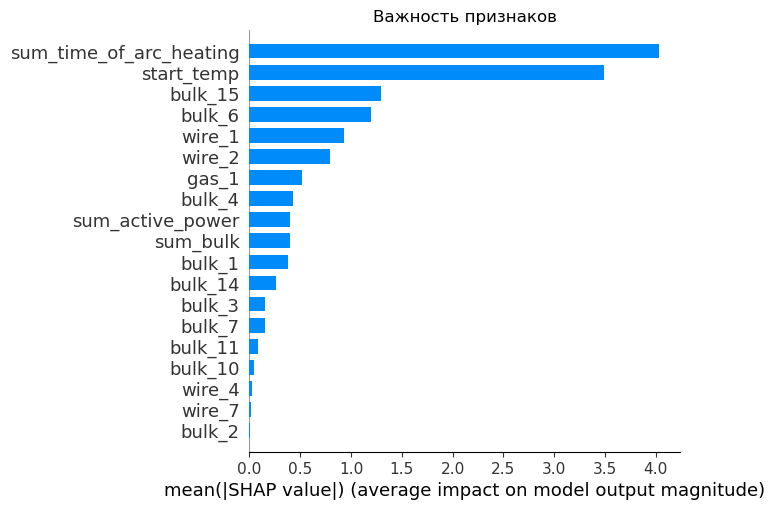

In [92]:
shap_test = shap.TreeExplainer(best_model).shap_values(features)
shap.summary_plot(shap_test, features, plot_type='bar', plot_size=(7, 5), show=False)
plt.title('Важность признаков')
plt.show()

Большую значимость имеют суммарное время нагрева и стартовая температура.

## Отчет

# Ответы на вопросы

**1. Какие пункты плана были выполнены, а какие - нет (поясните, почему?)**

```
План работы
1. Заполнить пропуски, удалить выбросы, изменить тип данных
2. Подготовить таблицы к объединения и объединить
3. Посмотреть корреляцию, отобрать признаки
4. Разделить на 2 выборки - обучающую и тестовую (тк данных не шибко много)
5. Обучить несколько моделей с разными гиперпараметрами, выбрать лучшую модель
```
Были выполнены все пункты плана

**2. Какие трудности возникли и как вы их преодолели?**

Проблем со стороны понимания и логики работы не было, но были затупы с кодом. Решилось все гуглом и stackoverflow/документацией.

**3. Какие ключевые шаги в решении задачи выделили?**

Первое, понять какие данные могут помочь в решении, в целом, правильное понимание задачи. Второе, анализ данных (пропуски, выбросы). Третье, предобработка данных (заполнение/удаление пропусков, удаление выбросов). Четвертое, подбор модели и гиперпараметров. Ну и пятое, проверка лучшей модели на тестовой выборе.

**4. Какая ваша итоговая модель и какое у нее качество?**

Лучше всего себя показал CatBoostRegressor, на трейне MAE 6.23, на тесте - 6.07.

# Признаки и их предобработка

- start_temp - стартовая температура, была взята из таблицы data_temp (результаты измерения температуры), самое первое измерение температуры у партии, брались только те партии, у которых не было пропусков;
- sum_bulk - суммарный объем сыпучих материалов по партиям, пропуски в отдельных материалах были заполнены 0. Объем сыпучих материалов был взят из таблицы data_bulk (данные о подаче сыпучих материалов (объём));
- bulk_15, bulk_14, bulk_11, bulk_10, bulk_7, bulk_6, bulk_4, bulk_3, bulk_2, bulk_1 - объем сыпучего материала номер N, пропуски были заполнены 0. Взят из таблицы data_bulk (данные о подаче сыпучих материалов (объём));
- wire_7, wire_4, wire_2, wire_1 - объем проволочного материала номер N, пропуски были заполнены 0. Взят из таблицы data_wire (данные о проволочных материалах (объём));
- sum_active_power - суммарная активная мощность по партиям, изначально мощность была взята из таблицы data_arc (данные об электродах), брались только строки, у которых реактивная мощность больше 0.
- sum_time_of_arc_heating - суммарное время нагрева дугой, сначала находилось время каждого нагрева, после суммировалось по партиям, было переведено в секунды;
- gas_1 - продувка сплава газом, взято из таблицы data_gas (данные о продувке сплава газом), были убраны все партии, где значение было больше 60.

# Гиперпараметры лучшей модели

CatBoostRegressor:
- verbose: 20,
- random_seed: 80523,
- learning_rate: 0.15,
- iterations' 100,
- depth: 6.

# Что рекомендуете для улучшения модели, решения

Поэкспериментировать с добавлением разных признаков, что-то убрать (bulk_2 мозолит глаза), что-то добавить (например, количество нагревов)